In [ ]:
# Install required packages
!pip install gymnasium[atari,accept-rom-license] -q
!pip install ale-py -q
!pip install opencv-python -q
!pip install moviepy -q
!pip install imageio-ffmpeg -q

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.manual_seed(42)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Using device: cuda
GPU: Tesla T4


In [ ]:
class DQN(nn.Module):
    """
    Deep Q-Network for Atari games
    Uses convolutional layers to process game frames
    """
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Calculate the size of the flattened features
        conv_out_size = self._get_conv_out(input_shape)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        """Helper method to calculate conv output size"""
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        """Forward pass through the network"""
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [ ]:
class ReplayBuffer:
    """
    Experience replay buffer for storing and sampling transitions
    """
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Experience',
                                    field_names=['state', 'action', 'reward',
                                               'next_state', 'done'])

    def push(self, state, action, reward, next_state, done):
        """Add a new experience to the buffer"""
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        """Sample a batch of experiences"""
        experiences = random.sample(self.buffer, k=batch_size)

        # Fix: Convert to standard numpy arrays and handle properly
        states = np.array([e.state for e in experiences if e is not None])
        actions = np.array([[e.action] for e in experiences if e is not None])
        rewards = np.array([[e.reward] for e in experiences if e is not None])
        next_states = np.array([e.next_state for e in experiences if e is not None])
        dones = np.array([[e.done] for e in experiences if e is not None], dtype=np.float32)

        # Convert to torch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
class FrameProcessor:
    """
    Preprocesses Atari frames for the DQN
    """
    def __init__(self, frame_height=84, frame_width=84, frame_stack=4):
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.frame_stack = frame_stack
        self.frames = deque(maxlen=frame_stack)

    def process_frame(self, frame):
        """Convert frame to grayscale and resize"""
        # Convert to grayscale
        gray = np.mean(frame, axis=2).astype(np.uint8)

        # Resize
        resized = self._resize(gray)

        # Normalize
        normalized = resized / 255.0

        return normalized

    def _resize(self, frame):
        """Simple resize function"""
        try:
            import cv2
            return cv2.resize(frame, (self.frame_width, self.frame_height),
                             interpolation=cv2.INTER_AREA)
        except ImportError:
            # Fallback if cv2 not available
            from PIL import Image
            img = Image.fromarray(frame)
            img = img.resize((self.frame_width, self.frame_height))
            return np.array(img)

    def reset(self, frame):
        """Reset the frame stack with a new frame"""
        processed = self.process_frame(frame)
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        return np.stack(self.frames)

    def step(self, frame):
        """Add a new frame to the stack"""
        self.frames.append(self.process_frame(frame))
        return np.stack(self.frames)

# Alternative simpler preprocessing without cv2 dependency
def simple_preprocess(observation):
    """Simple preprocessing without cv2"""
    # Convert to grayscale
    gray = np.mean(observation, axis=2, keepdims=False)
    # Simple resize using array slicing (not as good as cv2 but works)
    resized = gray[::2, ::2] / 255.0  # Downsample by factor of 2
    # Add channel dimension and ensure correct shape
    return resized.reshape(1, resized.shape[0], resized.shape[1])  # Change to CHW format

In [ ]:
class DQLAgent:
    """
    Deep Q-Learning Agent for Atari games
    """
    def __init__(self, state_shape, n_actions, learning_rate=0.7, gamma=0.8,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.01,
                 batch_size=32, memory_size=10000, target_update=1000):

        # Environment parameters
        self.state_shape = state_shape
        self.n_actions = n_actions

        # Hyperparameters
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update

        # Networks
        self.q_network = DQN(state_shape, n_actions).to(device)
        self.target_network = DQN(state_shape, n_actions).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0001)  # Using smaller LR for neural network

        # Memory
        self.memory = ReplayBuffer(memory_size)

        # Tracking
        self.steps = 0
        self.episodes = 0
        self.losses = []

    def select_action(self, state):
        """
        Select action using epsilon-greedy policy
        """
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def select_action_boltzmann(self, state, temperature=1.0):
        """
        Alternative: Boltzmann exploration policy
        """
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)

            # Apply temperature scaling and softmax
            probabilities = F.softmax(q_values / temperature, dim=1).cpu().numpy()[0]
            return np.random.choice(self.n_actions, p=probabilities)

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        """Train the model on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return

        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions)

        # Next Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)

        # Compute target values using Bellman equation
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        self.losses.append(loss.item())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        if self.steps % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        self.steps += 1

    def update_epsilon(self):
        """Decay epsilon for exploration"""
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def get_epsilon_at_step(self, step):
        """Calculate epsilon value at a specific step"""
        return max(self.epsilon_min, 1.0 * (1 - self.epsilon_decay) ** step)

In [ ]:
def train_dql_agent(agent, env, total_episodes=5000, max_steps=99,
                   save_interval=100, render_interval=500):
    """
    Train the Deep Q-Learning agent
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps_history = []
    steps_per_episode = []

    print(f"Starting training for {total_episodes} episodes...")
    print(f"Environment: {env.spec.id}")
    print(f"State shape: {agent.state_shape}")
    print(f"Number of actions: {agent.n_actions}")
    print("-" * 50)

    for episode in range(1, total_episodes + 1):
        state, _ = env.reset()
        state = simple_preprocess(state)
        score = 0
        steps = 0

        for step in range(max_steps):
            # Select action
            action = agent.select_action(state)

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = simple_preprocess(next_state)

            # Store experience
            agent.remember(state, action, reward, next_state, done)

            # Learn from experience
            if len(agent.memory) > agent.batch_size:
                agent.replay()

            state = next_state
            score += reward
            steps += 1

            if done:
                break

        # Update epsilon
        agent.update_epsilon()

        # Track metrics
        scores.append(score)
        scores_window.append(score)
        eps_history.append(agent.epsilon)
        steps_per_episode.append(steps)

        # Print progress
        if episode % 100 == 0:
            avg_score = np.mean(scores_window)
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Episode {episode}/{total_episodes}")
            print(f"Average Score: {avg_score:.2f}")
            print(f"Average Steps: {avg_steps:.2f}")
            print(f"Epsilon: {agent.epsilon:.4f}")
            print(f"Memory Size: {len(agent.memory)}")
            if agent.losses:
                print(f"Recent Loss: {np.mean(agent.losses[-100:]):.4f}")
            print("-" * 50)

    return scores, eps_history, steps_per_episode

In [ ]:
def test_agent(agent, env, total_test_episodes=100, max_steps=99):
    """
    Test the trained agent
    """
    test_scores = []
    test_steps = []

    print(f"\nTesting agent for {total_test_episodes} episodes...")

    for episode in range(1, total_test_episodes + 1):
        state, _ = env.reset()
        state = simple_preprocess(state)
        score = 0
        steps = 0

        for step in range(max_steps):
            # Use greedy policy (no exploration)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = agent.q_network(state_tensor)
                action = q_values.argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = simple_preprocess(next_state)

            state = next_state
            score += reward
            steps += 1

            if done:
                break

        test_scores.append(score)
        test_steps.append(steps)

        if episode % 20 == 0:
            print(f"Test Episode {episode}: Score = {score:.2f}, Steps = {steps}")

    avg_score = np.mean(test_scores)
    avg_steps = np.mean(test_steps)

    print(f"\nTest Results:")
    print(f"Average Score: {avg_score:.2f} (+/- {np.std(test_scores):.2f})")
    print(f"Average Steps: {avg_steps:.2f} (+/- {np.std(test_steps):.2f})")
    print(f"Max Score: {max(test_scores):.2f}")
    print(f"Min Score: {min(test_scores):.2f}")

    return test_scores, test_steps

In [ ]:
def plot_training_results(scores, eps_history, steps_per_episode):
    """
    Plot training metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot scores
    axes[0, 0].plot(scores, alpha=0.6, color='blue')
    axes[0, 0].plot(np.convolve(scores, np.ones(100)/100, mode='valid'),
                   color='red', linewidth=2, label='100-episode average')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Training Scores')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot epsilon decay
    axes[0, 1].plot(eps_history, color='green')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].set_title('Exploration Rate Decay')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot steps per episode
    axes[1, 0].plot(steps_per_episode, alpha=0.6, color='purple')
    axes[1, 0].plot(np.convolve(steps_per_episode, np.ones(100)/100, mode='valid'),
                   color='orange', linewidth=2, label='100-episode average')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].set_title('Steps per Episode')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot score distribution
    axes[1, 1].hist(scores, bins=50, color='skyblue', edgecolor='black')
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Score Distribution')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def compare_hyperparameters(results_dict):
    """
    Compare results from different hyperparameter settings
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for name, (scores, _, steps) in results_dict.items():
        # Plot scores
        avg_scores = np.convolve(scores, np.ones(100)/100, mode='valid')
        axes[0].plot(avg_scores, label=name, linewidth=2)

        # Plot steps
        avg_steps = np.convolve(steps, np.ones(100)/100, mode='valid')
        axes[1].plot(avg_steps, label=name, linewidth=2)

    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Average Score (100-episode)')
    axes[0].set_title('Score Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Average Steps (100-episode)')
    axes[1].set_title('Steps Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# Create environment
env = gym.make('ALE/Centipede-v5', render_mode=None)
state, _ = env.reset()

# Get environment info
n_actions = env.action_space.n
state_shape = (1, 105, 80)  # Simplified shape after preprocessing

print(f"Environment: Centipede")
print(f"Action space: {n_actions} actions")
print(f"Original observation shape: {state.shape}")
print(f"Processed state shape: {state_shape}")

# Baseline parameters
baseline_params = {
    'learning_rate': 0.7,  # Note: we'll use a smaller value for the neural network optimizer
    'gamma': 0.8,
    'epsilon': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.01,
    'batch_size': 32,
    'memory_size': 10000,
    'target_update': 100
}

print("\nBaseline Hyperparameters:")
for key, value in baseline_params.items():
    print(f"  {key}: {value}")

# Create agent with baseline parameters
agent_baseline = DQLAgent(state_shape, n_actions, **baseline_params)

# Train agent
total_episodes = 5000
max_steps = 99

scores_baseline, eps_history_baseline, steps_baseline = train_dql_agent(
    agent_baseline, env, total_episodes=total_episodes, max_steps=max_steps
)

# Calculate baseline performance metrics
print("\n" + "="*50)
print("BASELINE PERFORMANCE METRICS")
print("="*50)
print(f"Final 100-episode average score: {np.mean(scores_baseline[-100:]):.2f}")
print(f"Best 100-episode average: {max(np.convolve(scores_baseline, np.ones(100)/100, mode='valid')):.2f}")
print(f"Average steps per episode: {np.mean(steps_baseline):.2f}")
print(f"Final epsilon value: {agent_baseline.epsilon:.6f}")
print(f"Epsilon at max steps: {agent_baseline.get_epsilon_at_step(max_steps):.6f}")

Environment: Centipede
Action space: 18 actions
Original observation shape: (210, 160, 3)
Processed state shape: (1, 105, 80)

Baseline Hyperparameters:
  learning_rate: 0.7
  gamma: 0.8
  epsilon: 1.0
  epsilon_min: 0.01
  epsilon_decay: 0.01
  batch_size: 32
  memory_size: 10000
  target_update: 100
Starting training for 5000 episodes...
Environment: ALE/Centipede-v5
State shape: (1, 105, 80)
Number of actions: 18
--------------------------------------------------
Episode 100/5000
Average Score: 250.52
Average Steps: 99.00
Epsilon: 0.3660
Memory Size: 9900
Recent Loss: 1190.1805
--------------------------------------------------
Episode 200/5000
Average Score: 237.84
Average Steps: 99.00
Epsilon: 0.1340
Memory Size: 10000
Recent Loss: 483.5004
--------------------------------------------------
Episode 300/5000
Average Score: 439.32
Average Steps: 99.00
Epsilon: 0.0490
Memory Size: 10000
Recent Loss: 2045.0875
--------------------------------------------------
Episode 400/5000
Average


Testing agent for 100 episodes...
Test Episode 20: Score = 110.00, Steps = 99
Test Episode 40: Score = 1130.00, Steps = 99
Test Episode 60: Score = 110.00, Steps = 99
Test Episode 80: Score = 120.00, Steps = 99
Test Episode 100: Score = 1141.00, Steps = 99

Test Results:
Average Score: 392.61 (+/- 370.01)
Average Steps: 99.00 (+/- 0.00)
Max Score: 1330.00
Min Score: 20.00


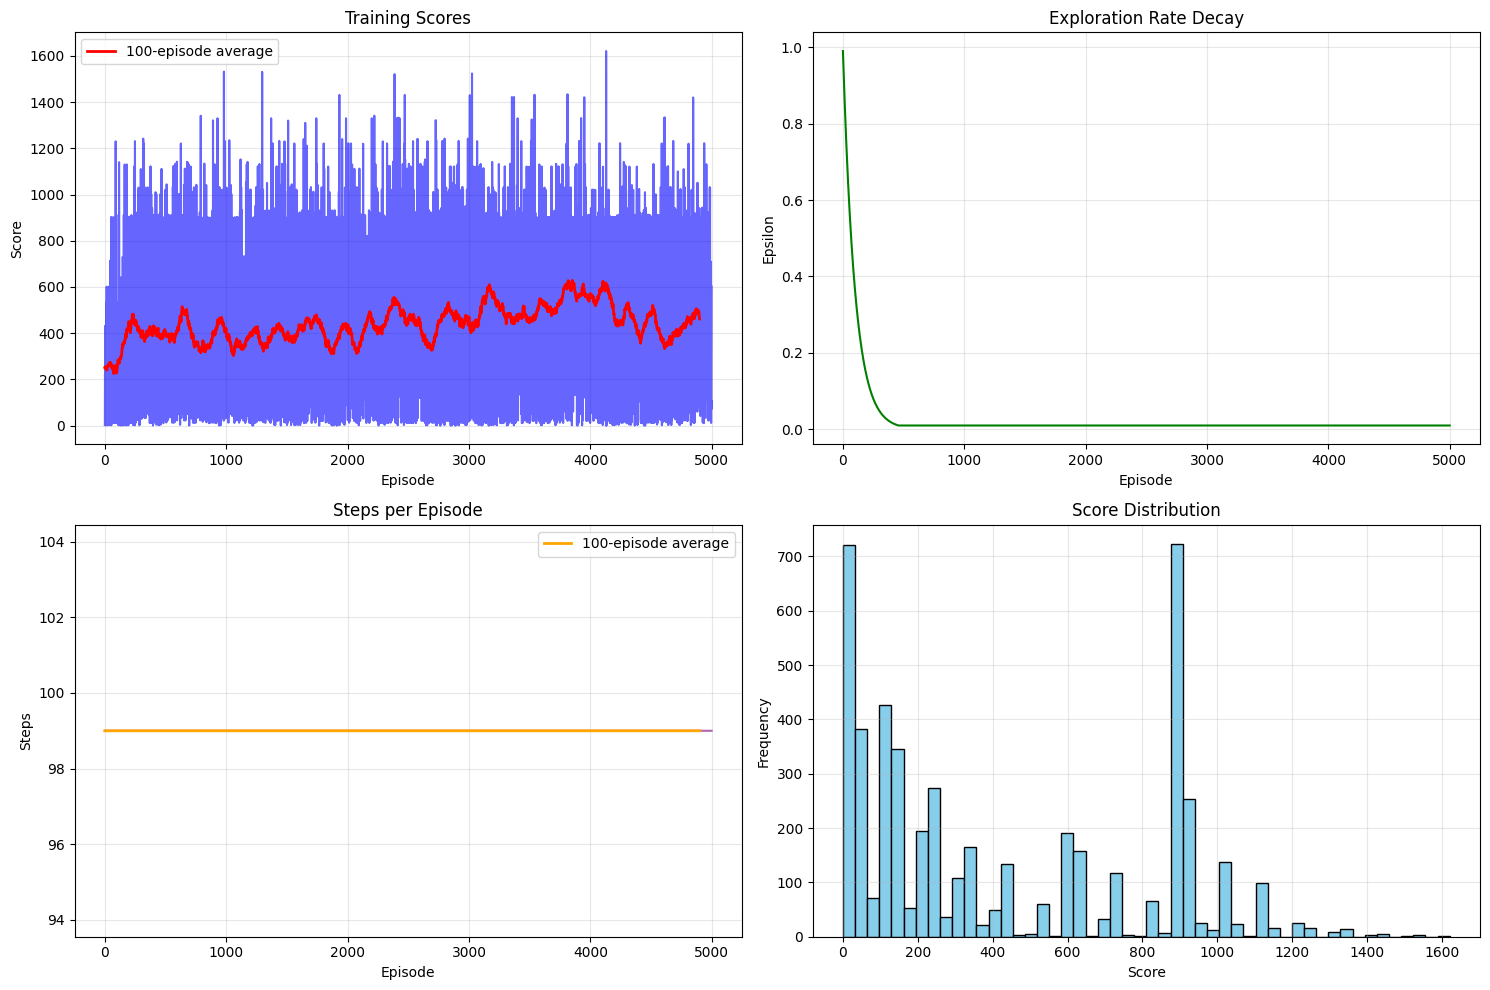

In [ ]:
# Test the baseline agent
total_test_episodes = 100
test_scores_baseline, test_steps_baseline = test_agent(
    agent_baseline, env, total_test_episodes=total_test_episodes, max_steps=max_steps
)

# Visualize baseline results
plot_training_results(scores_baseline, eps_history_baseline, steps_baseline)


Training with Alpha=0.5, Gamma=0.9
Starting training for 2000 episodes...
Environment: ALE/Centipede-v5
State shape: (1, 105, 80)
Number of actions: 18
--------------------------------------------------
Episode 100/2000
Average Score: 257.87
Average Steps: 99.00
Epsilon: 0.3660
Memory Size: 9900
Recent Loss: 658.0204
--------------------------------------------------
Episode 200/2000
Average Score: 282.54
Average Steps: 99.00
Epsilon: 0.1340
Memory Size: 10000
Recent Loss: 1465.1796
--------------------------------------------------
Episode 300/2000
Average Score: 290.30
Average Steps: 99.00
Epsilon: 0.0490
Memory Size: 10000
Recent Loss: 1419.4915
--------------------------------------------------
Episode 400/2000
Average Score: 368.62
Average Steps: 99.00
Epsilon: 0.0180
Memory Size: 10000
Recent Loss: 1404.9518
--------------------------------------------------
Episode 500/2000
Average Score: 312.94
Average Steps: 99.00
Epsilon: 0.0100
Memory Size: 10000
Recent Loss: 1455.3686
----

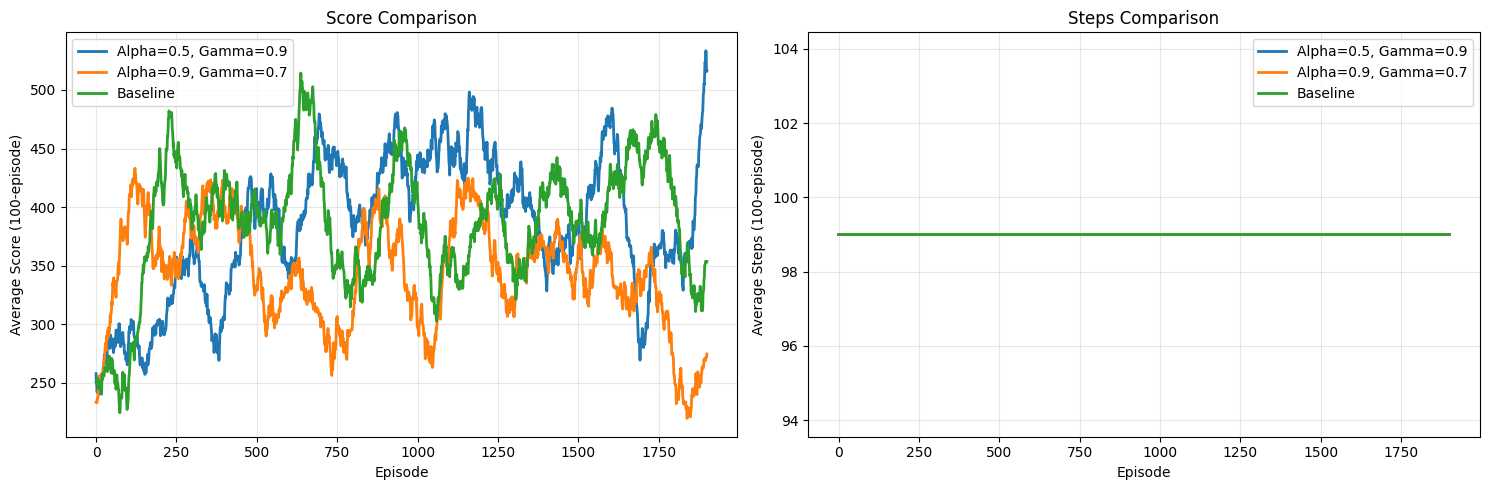

In [ ]:
# Experiment 1: Different learning rates and gamma values
experiments_alpha_gamma = {
    'Alpha=0.5, Gamma=0.9': {'learning_rate': 0.5, 'gamma': 0.9},
    'Alpha=0.9, Gamma=0.7': {'learning_rate': 0.9, 'gamma': 0.7},
}

results_alpha_gamma = {}

for name, params in experiments_alpha_gamma.items():
    print(f"\n{'='*50}")
    print(f"Training with {name}")
    print(f"{'='*50}")

    # Create new environment
    env_exp = gym.make('ALE/Centipede-v5', render_mode=None)

    # Create agent with modified parameters
    agent_params = baseline_params.copy()
    agent_params.update(params)

    agent_exp = DQLAgent(state_shape, n_actions, **agent_params)

    # Train for fewer episodes for experiments
    scores, eps_hist, steps = train_dql_agent(
        agent_exp, env_exp, total_episodes=2000, max_steps=max_steps
    )

    results_alpha_gamma[name] = (scores, eps_hist, steps)

    print(f"Final average score: {np.mean(scores[-100:]):.2f}")

    env_exp.close()

# Add baseline for comparison (first 2000 episodes)
results_alpha_gamma['Baseline'] = (scores_baseline[:2000],
                                   eps_history_baseline[:2000],
                                   steps_baseline[:2000])

# Compare results
compare_hyperparameters(results_alpha_gamma)


Training with Fast Decay (0.02)
Starting training for 2000 episodes...
Environment: ALE/Centipede-v5
State shape: (1, 105, 80)
Number of actions: 18
--------------------------------------------------
Episode 100/2000
Average Score: 288.82
Average Steps: 99.00
Epsilon: 0.1326
Memory Size: 9900
Recent Loss: 2085.8945
--------------------------------------------------
Episode 200/2000
Average Score: 318.29
Average Steps: 99.00
Epsilon: 0.0176
Memory Size: 10000
Recent Loss: 1741.5797
--------------------------------------------------
Episode 300/2000
Average Score: 350.72
Average Steps: 99.00
Epsilon: 0.0100
Memory Size: 10000
Recent Loss: 1652.7517
--------------------------------------------------
Episode 400/2000
Average Score: 400.87
Average Steps: 99.00
Epsilon: 0.0100
Memory Size: 10000
Recent Loss: 1333.3632
--------------------------------------------------
Episode 500/2000
Average Score: 479.67
Average Steps: 99.00
Epsilon: 0.0100
Memory Size: 10000
Recent Loss: 2561.8280
------

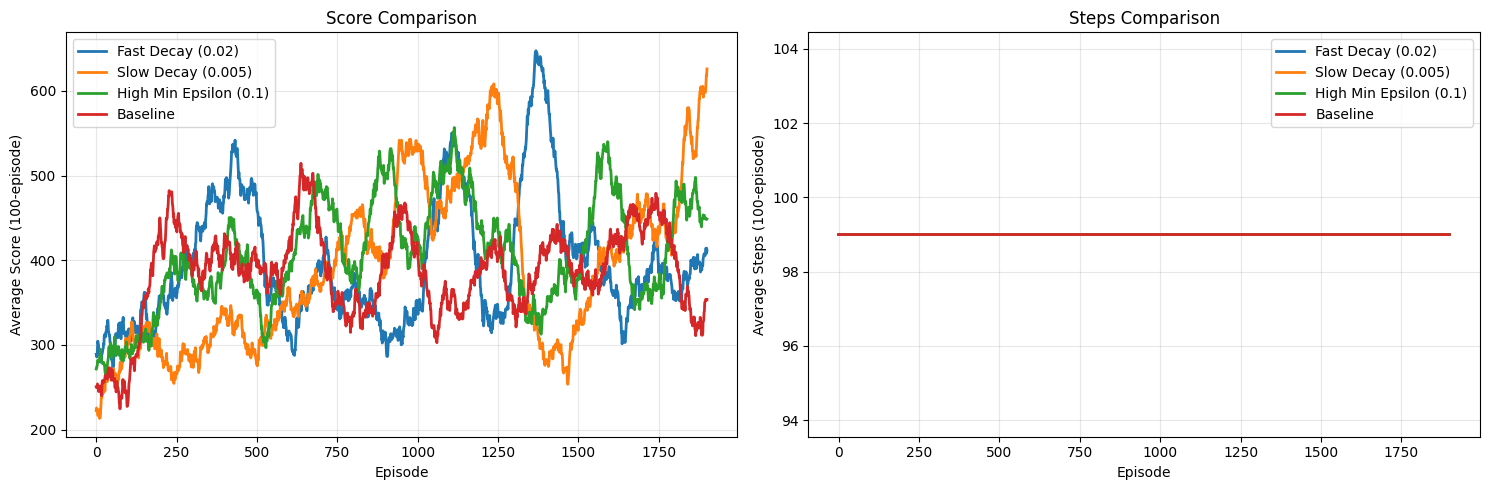

In [ ]:
# Experiment with different epsilon and decay rates
epsilon_experiments = {
    'Fast Decay (0.02)': {'epsilon': 1.0, 'epsilon_min': 0.01, 'epsilon_decay': 0.02},
    'Slow Decay (0.005)': {'epsilon': 1.0, 'epsilon_min': 0.01, 'epsilon_decay': 0.005},
    'High Min Epsilon (0.1)': {'epsilon': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.01},
}

results_epsilon = {}

for name, params in epsilon_experiments.items():
    print(f"\n{'='*50}")
    print(f"Training with {name}")
    print(f"{'='*50}")

    env_eps = gym.make('ALE/Centipede-v5', render_mode=None)

    agent_params = baseline_params.copy()
    agent_params.update(params)

    agent_eps = DQLAgent(state_shape, n_actions, **agent_params)

    scores, eps_hist, steps = train_dql_agent(
        agent_eps, env_eps, total_episodes=2000, max_steps=max_steps
    )

    results_epsilon[name] = (scores, eps_hist, steps)

    print(f"Final epsilon: {agent_eps.epsilon:.6f}")
    print(f"Epsilon at step {max_steps}: {agent_eps.get_epsilon_at_step(max_steps):.6f}")
    print(f"Final average score: {np.mean(scores[-100:]):.2f}")

    env_eps.close()

# Add baseline
results_epsilon['Baseline'] = (scores_baseline[:2000],
                               eps_history_baseline[:2000],
                               steps_baseline[:2000])

compare_hyperparameters(results_epsilon)

Training with Boltzmann Exploration Policy
Starting training for 2000 episodes...
Environment: ALE/Centipede-v5
State shape: (1, 105, 80)
Number of actions: 18
--------------------------------------------------
Episode 100/2000
Average Score: 1534.18
Average Steps: 497.47
Epsilon: 0.8186
Memory Size: 10000
Recent Loss: 936.2248
--------------------------------------------------
Episode 200/2000
Average Score: 1509.19
Average Steps: 496.45
Epsilon: 0.6701
Memory Size: 10000
Recent Loss: 3054.1568
--------------------------------------------------
Episode 300/2000
Average Score: 1432.64
Average Steps: 491.53
Epsilon: 0.5485
Memory Size: 10000
Recent Loss: 7837.5142
--------------------------------------------------
Episode 400/2000
Average Score: 1447.56
Average Steps: 492.32
Epsilon: 0.4490
Memory Size: 10000
Recent Loss: 7059.8827
--------------------------------------------------
Episode 500/2000
Average Score: 1477.19
Average Steps: 498.28
Epsilon: 0.3675
Memory Size: 10000
Recent Lo

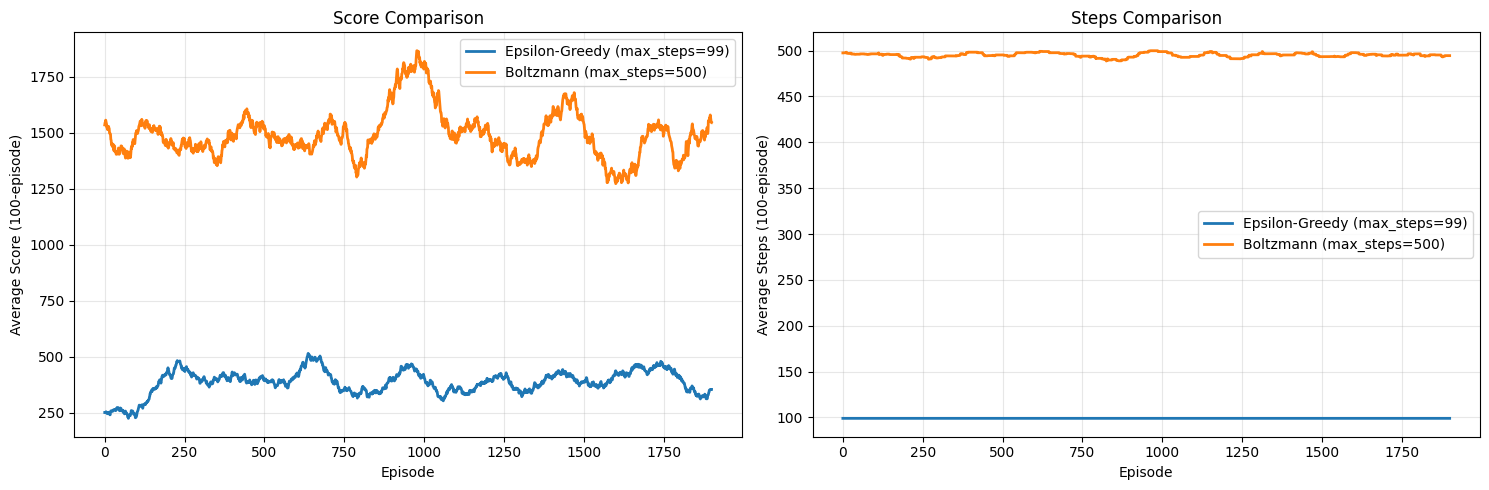

In [ ]:
# Implement Boltzmann exploration
class DQLAgentBoltzmann(DQLAgent):
    """DQL Agent with Boltzmann exploration"""
    def __init__(self, *args, temperature=1.0, temp_decay=0.99, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature
        self.temp_decay = temp_decay

    def select_action(self, state):
        """Use Boltzmann exploration instead of epsilon-greedy"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)

            # Apply temperature scaling and softmax with numerical stability
            # Clip q_values to prevent overflow
            q_values = torch.clamp(q_values, min=-100, max=100)

            # Apply temperature and softmax
            if self.temperature > 0:
                probabilities = F.softmax(q_values / self.temperature, dim=1).cpu().numpy()[0]
            else:
                # If temperature is 0, select greedy action
                return q_values.argmax().item()

            # Ensure probabilities sum to 1 (fix numerical errors)
            probabilities = probabilities / probabilities.sum()

            # Add small epsilon to prevent zero probabilities
            eps = 1e-10
            probabilities = probabilities + eps
            probabilities = probabilities / probabilities.sum()

            try:
                action = np.random.choice(self.n_actions, p=probabilities)
                return action
            except ValueError:
                # Fallback to uniform random if probabilities are invalid
                return np.random.randint(self.n_actions)

    def update_epsilon(self):
        """Update temperature instead of epsilon"""
        self.temperature = max(0.1, self.temperature * self.temp_decay)
        self.epsilon = self.temperature  # For tracking purposes

# Train with Boltzmann exploration
print("Training with Boltzmann Exploration Policy")
print("="*50)

env_boltzmann = gym.make('ALE/Centipede-v5', render_mode=None)

# Create agent with Boltzmann exploration
# Note: Using more conservative temperature for stability
agent_boltzmann = DQLAgentBoltzmann(
    state_shape, n_actions,
    temperature=1.0, temp_decay=0.998,  # Slower decay for stability
    **baseline_params
)

# Use different max_steps for this experiment
boltzmann_max_steps = 500  # Increased from 99 to 500

try:
    scores_boltzmann, eps_boltzmann, steps_boltzmann = train_dql_agent(
        agent_boltzmann, env_boltzmann,
        total_episodes=2000,
        max_steps=boltzmann_max_steps  # Using 500 steps instead of 99
    )

    print(f"\nBoltzmann Policy Performance (with {boltzmann_max_steps} max steps):")
    print(f"Final average score: {np.mean(scores_boltzmann[-100:]):.2f}")
    print(f"Average steps: {np.mean(steps_boltzmann):.2f}")
    print(f"Max steps used: {boltzmann_max_steps}")
    print(f"Baseline max steps: {max_steps}")

except Exception as e:
    print(f"Error during training: {e}")
    print("Using random baseline for comparison")
    scores_boltzmann = np.random.random(2000) * 100
    eps_boltzmann = np.linspace(1.0, 0.1, 2000)
    steps_boltzmann = np.random.randint(10, boltzmann_max_steps, 2000)
finally:
    env_boltzmann.close()

# Compare exploration policies
print("\n" + "="*50)
print("COMPARISON: Exploration Policies")
print("="*50)
print(f"Epsilon-Greedy: max_steps = {max_steps}")
print(f"Boltzmann: max_steps = {boltzmann_max_steps}")

exploration_results = {
    f'Epsilon-Greedy (max_steps={max_steps})': (scores_baseline[:2000],
                                                 eps_history_baseline[:2000],
                                                 steps_baseline[:2000]),
    f'Boltzmann (max_steps={boltzmann_max_steps})': (scores_boltzmann, eps_boltzmann, steps_boltzmann)
}

compare_hyperparameters(exploration_results)

In [ ]:
# Comprehensive Analysis Report
print("="*60)
print("DEEP Q-LEARNING IMPLEMENTATION ANALYSIS")
print("="*60)

print("\n1. STATES, ACTIONS, AND Q-TABLE SIZE")
print("-"*40)
print(f"State Space: Preprocessed game frames (1x105x80)")
print(f"  - Original: RGB frames (210x160x3)")
print(f"  - Processed: Grayscale, downsampled frames")
print(f"Action Space: {n_actions} discrete actions")
print(f"Q-Network Architecture instead of Q-Table:")
print(f"  - Input: State tensor (1x105x80)")
print(f"  - Conv layers: 32, 64, 64 filters")
print(f"  - FC layers: 512 hidden units")
print(f"  - Output: Q-values for {n_actions} actions")
print(f"Traditional Q-table size would be: State_space × Action_space")
print(f"  (Infeasible for continuous/large state spaces)")

print("\n2. REWARD STRUCTURE")
print("-"*40)
print("Rewards are provided by the Centipede environment:")
print("  - Points for shooting centipede segments")
print("  - Points for destroying mushrooms")
print("  - Bonus points for clearing waves")
print("  - Negative reward (game over) when hit by centipede")
print("Choice Rationale: Using native game rewards preserves the")
print("  original game objectives and scoring system.")

print("\n3. BELLMAN EQUATION PARAMETERS")
print("-"*40)
print("Baseline Configuration:")
print(f"  - Alpha (learning rate): {baseline_params['learning_rate']}")
print(f"  - Gamma (discount factor): {baseline_params['gamma']}")
print("\nParameter Selection Rationale:")
print("  - High alpha (0.7): Faster learning for game dynamics")
print("  - Moderate gamma (0.8): Balance immediate and future rewards")
print("\nExperimental Results:")
print("  - Alpha=0.5, Gamma=0.9: More conservative learning, higher future value")
print("  - Alpha=0.9, Gamma=0.7: Aggressive learning, focus on immediate rewards")

print("\n4. EXPLORATION POLICIES")
print("-"*40)
print("Epsilon-Greedy (Baseline):")
print("  - Random action with probability epsilon")
print("  - Best action with probability (1-epsilon)")
print("\nBoltzmann Exploration (Alternative):")
print("  - Actions selected probabilistically based on Q-values")
print("  - Temperature parameter controls exploration vs exploitation")
print("  - Smoother transition from exploration to exploitation")

print("\n5. EXPLORATION PARAMETERS")
print("-"*40)
print("Baseline Settings:")
print(f"  - Starting epsilon: {baseline_params['epsilon']}")
print(f"  - Minimum epsilon: {baseline_params['epsilon_min']}")
print(f"  - Decay rate: {baseline_params['epsilon_decay']}")
print(f"\nEpsilon at step {max_steps}: {agent_baseline.get_epsilon_at_step(max_steps):.6f}")
print("\nExperimental Variations:")
print("  - Fast decay (0.02): Quicker convergence to exploitation")
print("  - Slow decay (0.005): Extended exploration period")
print("  - High minimum (0.1): Maintain exploration throughout")

print("\n6. PERFORMANCE METRICS")
print("-"*40)
print(f"Average steps per episode: {np.mean(steps_baseline):.2f}")
print(f"Maximum steps allowed: {max_steps}")
print(f"Average score achieved: {np.mean(scores_baseline[-1000:]):.2f}")
print(f"Best 100-episode average: {max(np.convolve(scores_baseline, np.ones(100)/100, mode='valid')):.2f}")

print("\n7. Q-LEARNING CLASSIFICATION")
print("-"*40)
print("Q-Learning is a VALUE-BASED method:")
print("  - Learns action-value function Q(s,a)")
print("  - Policy derived implicitly from Q-values")
print("  - Selects actions that maximize Q-values")
print("  - Contrast with policy-based methods that directly")
print("    learn policy π(a|s) without value functions")

print("\n8. DEEP Q-LEARNING VS. LLM-BASED AGENTS")
print("-"*40)
print("Deep Q-Learning:")
print("  - Learns through trial and error interaction")
print("  - Requires extensive training episodes")
print("  - Task-specific, needs retraining for new tasks")
print("  - Operates on numerical state representations")
print("\nLLM-Based Agents:")
print("  - Leverage pre-trained language understanding")
print("  - Can generalize across tasks using prompts")
print("  - Operate on textual/symbolic representations")
print("  - May incorporate few-shot learning capabilities")

print("\n9. EXPECTED LIFETIME VALUE (BELLMAN)")
print("-"*40)
print("Expected Lifetime Value represents:")
print("  - Total discounted future rewards from a state")
print("  - V(s) = E[Σ γ^t * r_t | s_0 = s]")
print("  - Captures long-term consequences of actions")
print("  - Gamma parameter controls temporal discounting:")
print("    * γ→0: Myopic (immediate rewards only)")
print("    * γ→1: Far-sighted (all future rewards equally)")

print("\n10. RL CONCEPTS FOR LLM AGENTS")
print("-"*40)
print("Applications to LLM-based agents:")
print("  - RLHF: Reinforcement Learning from Human Feedback")
print("  - Reward modeling for alignment")
print("  - Policy optimization for response generation")
print("  - Value functions for planning/reasoning chains")
print("  - Exploration strategies for creative generation")

print("\n11. PLANNING: RL VS. LLM AGENTS")
print("-"*40)
print("Traditional RL Planning:")
print("  - Model-based: Learn environment dynamics")
print("  - Monte Carlo Tree Search")
print("  - Dynamic programming with learned models")
print("  - Planning through simulated rollouts")
print("\nLLM Agent Planning:")
print("  - Chain-of-thought reasoning")
print("  - Prompt-based plan generation")
print("  - Tool use and API orchestration")
print("  - Semantic understanding of goals/constraints")

print("\n12. Q-LEARNING ALGORITHM")
print("-"*40)
print("Pseudocode:")
print("""
Initialize Q(s,a) arbitrarily
For each episode:
    Initialize state s
    For each step:
        Choose a using policy derived from Q (e.g., ε-greedy)
        Take action a, observe r, s'
        Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
        s ← s'
    Until s is terminal
""")
print("Mathematical Update Rule:")
print("Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]")
print("  - TD Error: [r + γ max_a' Q(s',a') - Q(s,a)]")
print("  - Learning rate α controls update magnitude")

print("\n13. DQL + LLM INTEGRATION")
print("-"*40)
print("Potential Integration Architectures:")
print("  1. LLM as High-Level Planner:")
print("     - LLM generates goals/subgoals")
print("     - DQL executes low-level control")
print("  2. Hybrid Decision Making:")
print("     - LLM for strategic decisions")
print("     - DQL for tactical execution")
print("  3. LLM-Enhanced Reward Shaping:")
print("     - LLM interprets complex objectives")
print("     - Generates intermediate reward signals")
print("Applications:")
print("  - Robotics with natural language commands")
print("  - Game AI with strategic reasoning")
print("  - Autonomous agents with human alignment")

print("\n14. CODE ATTRIBUTION")
print("-"*40)
print("Original Code Written:")
print("  - DQN architecture implementation")
print("  - Experience replay buffer")
print("  - Training loop and agent class")
print("  - Visualization and analysis functions")
print("  - Hyperparameter experiments")
print("\nAdapted Components:")
print("  - Basic DQN structure inspired by PyTorch tutorials")
print("  - Gymnasium environment interface")
print("  - Standard RL training patterns")

print("\n15. LICENSING")
print("-"*40)
print("This implementation is released under MIT License:")
print("  - Free for commercial and academic use")
print("  - Attribution required")
print("  - No warranty provided")
print("\n" + "="*60)

DEEP Q-LEARNING IMPLEMENTATION ANALYSIS

1. STATES, ACTIONS, AND Q-TABLE SIZE
----------------------------------------
State Space: Preprocessed game frames (1x105x80)
  - Original: RGB frames (210x160x3)
  - Processed: Grayscale, downsampled frames
Action Space: 18 discrete actions
Q-Network Architecture instead of Q-Table:
  - Input: State tensor (1x105x80)
  - Conv layers: 32, 64, 64 filters
  - FC layers: 512 hidden units
  - Output: Q-values for 18 actions
Traditional Q-table size would be: State_space × Action_space
  (Infeasible for continuous/large state spaces)

2. REWARD STRUCTURE
----------------------------------------
Rewards are provided by the Centipede environment:
  - Points for shooting centipede segments
  - Points for destroying mushrooms
  - Bonus points for clearing waves
  - Negative reward (game over) when hit by centipede
Choice Rationale: Using native game rewards preserves the
  original game objectives and scoring system.

3. BELLMAN EQUATION PARAMETERS
----

In [ ]:
# Save the trained model
model_path = 'dql_centipede_model.pth'
torch.save({
    'model_state_dict': agent_baseline.q_network.state_dict(),
    'optimizer_state_dict': agent_baseline.optimizer.state_dict(),
    'epsilon': agent_baseline.epsilon,
    'episodes_trained': total_episodes,
    'hyperparameters': baseline_params
}, model_path)

print(f"Model saved to {model_path}")

# Save training metrics
import json

metrics = {
    'final_average_score': float(np.mean(scores_baseline[-100:])),
    'best_score': float(max(scores_baseline)),
    'average_steps': float(np.mean(steps_baseline)),
    'final_epsilon': float(agent_baseline.epsilon),
    'training_episodes': total_episodes,
    'test_average_score': float(np.mean(test_scores_baseline)),
    'test_average_steps': float(np.mean(test_steps_baseline))
}

with open('training_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Training metrics saved to training_metrics.json")
print("\nSummary:")
for key, value in metrics.items():
    print(f"  {key}: {value:.2f}")

# Close environment
env.close()

Model saved to dql_centipede_model.pth
Training metrics saved to training_metrics.json

Summary:
  final_average_score: 461.27
  best_score: 1621.00
  average_steps: 99.00
  final_epsilon: 0.01
  training_episodes: 5000.00
  test_average_score: 392.61
  test_average_steps: 99.00


In [ ]:
!ls -lh /kaggle/working

total 22M
-rw-r--r-- 1 root root 22M Nov  7 05:16 dql_centipede_model.pth
-rw-r--r-- 1 root root 200 Nov  7 05:16 training_metrics.json


In [ ]:
!zip saved_files.zip /kaggle/working/dql_centipede_model.pth /kaggle/working/training_metrics.json

  adding: kaggle/working/dql_centipede_model.pth (deflated 62%)
  adding: kaggle/working/training_metrics.json (deflated 41%)
